# SOMPZ
### The purpose of this notebook is to take a wide, deep and balrog catalogs and create N(z)'s

### 1. Load packages

In [84]:
import numpy as np
import h5py
import time
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy
import pickle as pkl
import matplotlib as mpl
from astropy.coordinates import SkyCoord
from astropy import units as u
import healpy as hp
import scipy

n_deep, n_wide = 48, 26
nbins = 30
zmin, zmax = 0., 2
assert ( (zmin>=0) & (zmax>=zmin) & (nbins>0) & (n_deep>0) & (n_wide>0) )
z_edges = np.linspace(zmin,zmax,nbins)
zs = .5*np.array([z_edges[i]+z_edges[i+1] for i in range(nbins-1)])

### 2. load functions

In [10]:
#add descriptions to functions!!!

def hist(a):
    '''
    Returns the counts of each bin in a histogram of sample a (numerical list-like object)
    '''
    return list(np.histogram(a, bins=z_edges, density=False)[0])

def flux2mag(flux):
    '''
    Converts fluxes to magnitudes
    '''
    return -2.5 * np.log10(flux) + 30

# gold cut delegated to specialized scripts see 
# [location of repo]/CSPZ/scripts/(Balrog_fg_mask_20231120.py and metacal_gold_mask.py)

def deep_cuts(df):
    '''
    places color cuts on deep field catalog
    Credit: Alex Alarcon
    '''
    
    # Mask flagged regions -- not needed, saved deep catalog already has flag cuts in place
#     mask = df.MASK_FLAGS_NIR==0
#     mask &= df.MASK_FLAGS==0
#     mask &= df.FLAGS_NIR==0
#     mask &= df.FLAGS==0
#     mask &= df.FLAGSTR=="b'ok'"
#     mask &= df.FLAGSTR_NIR=="b'ok'"
#     df = df[mask]
#     df = df.drop(columns=[
#         "MASK_FLAGS",
#         "MASK_FLAGS_NIR",
#         "FLAGS",
#         "FLAGS_NIR",
#         "FLAGSTR",
#         "FLAGSTR_NIR",
#     ])
    deep_bands_ = ["U","G","R","I","Z","J","H","KS"]
    # remove crazy colors, defined as two 
    # consecutive colors (e.g u-g, g-r, r-i, etc) 
    # that have a value smaler than -1
    mags_d = np.zeros((len(df),len(deep_bands_)))
    magerrs_d = np.zeros((len(df),len(deep_bands_)))

    for i,band in enumerate(deep_bands_):
        #print(i,band)
        mags_d[:,i] = flux2mag(df['BDF_FLUX_DERED_CALIB_%s'%band])

    colors = np.zeros((len(df),len(deep_bands_)-1))
    for i in range(len(deep_bands_)-1):
        colors[:,i] = mags_d[:,i] - mags_d[:,i+1]

    normal_colors = np.mean(colors > -1, axis=1) == 1
    normal_colors.sum()

    i = flux2mag(df.BDF_FLUX_DERED_CALIB_I.values)
    r = flux2mag(df.BDF_FLUX_DERED_CALIB_R.values)
    z = flux2mag(df.BDF_FLUX_DERED_CALIB_Z.values)
    k = flux2mag(df.BDF_FLUX_DERED_CALIB_KS.values)

    return (flux2mag(df.BDF_FLUX_DERED_CALIB_I.values) < 25)&(normal_colors)&((z-k) > 0.5*(r-z))

def foreground_gold(cat, ra_col='true_ra', dec_col='true_dec'):
    '''
    applies foreground mask to a given catalog
    '''
    #delegated to a separate script. see ../scripts/Balrog_fg_mask_20231120.py (gold and foreground cut applied together)
    MASK = hp.read_map('/project/chihway/dhayaa/DECADE/Gold_Foreground_20230520.fits') == 0
    return MASK[hp.ang2pix(4096, cat[ra_col].values, cat[dec_col].values, lonlat = True)]

### 3. Load relevant catalogs (wide, deep, balrog), apply relevant cuts and add relevant columns

In [7]:
wide = np.load('/project/chihway/raulteixeira/data/BPZ+SOM_mcal_gold_wide_26x26_ids+cells+fluxes.npz')['arr_0']
# opens .npz containing BPZ estimates, wide SOM cell assignments, ids, and fluxes. 
# Catalog has foreground and gold cut applied already.
wide = pd.DataFrame(wide) #convert to pandas dataframe for easier data manipulation

wide['wide_cells']=wide['cells'] #rename 'cells' column for easier identification
wide.drop(columns=['cells']) #see comment above

# bdf_wide = pd.read_hdf('/project2/chihway/raulteixeira/data/bdf_photometry/dr3_1_1_bdf_metacal_gold.h5', key='df')
# wide = wide.merge(bdf_wide, on='COADD_OBJECT_ID') # unnecessary unless you would like to do SOM imshow plots on the BDF photometry

,COADD_OBJECT_ID,FLUX_R,FLUX_ERR_R,FLUX_I,FLUX_ERR_I,FLUX_Z,FLUX_ERR_Z,CHI_SQ,ID,M_0,...,T_B,T_ML,Z_B,Z_B_MAX,Z_B_MIN,Z_MEAN,Z_ML,Z_SAMP,Z_SIG,wide_cells
0,7109304883,3697.074912,41.510975,4342.987764,49.896796,5399.346127,101.126423,0.572120,7109304883,20.794094,...,5.0,5.0,0.155,0.215000,0.097571,0.193081,0.165,0.445,0.163029,8
1,7109304892,1060.265660,32.105632,2483.591726,41.284574,3354.406431,87.896135,1.192293,7109304892,21.408283,...,2.0,2.0,0.775,0.863257,0.555000,0.709006,0.775,0.835,0.105364,590
2,7109304896,2632.422146,45.376178,3391.575227,68.988487,4295.313674,125.899520,0.326125,7109304896,21.130915,...,5.0,5.0,0.435,0.506352,0.285000,0.399023,0.365,0.455,0.104050,137
3,7109304898,2133.722123,38.464039,2287.077329,46.422072,3271.006405,99.938773,0.463370,7109304898,21.517611,...,5.0,5.0,0.365,0.435000,0.297129,0.388183,0.365,0.375,0.051087,133
4,7109304902,751.718904,53.678323,992.224432,54.098644,1250.526081,120.534894,0.008982,7109304902,22.695087,...,4.0,3.0,0.485,0.685000,0.285000,0.503720,0.215,0.315,0.209248,361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47341771,7238533745,314.153069,18.548237,505.979069,56.803356,633.341440,131.662368,0.567029,7238533745,23.360582,...,5.0,5.0,0.805,1.035000,0.625000,0.826410,0.795,1.475,0.265486,437
47341772,7238533748,964.399538,15.952696,1356.360993,43.581431,1415.369620,57.492529,0.093127,7238533748,22.206959,...,5.0,2.0,0.515,0.590330,0.265000,0.429240,0.175,0.515,0.131464,93
47341773,7238533765,911.598527,10.944956,1507.449772,39.471370,1832.381211,56.297044,1.375936,7238533765,22.136280,...,4.0,2.0,0.715,0.800274,0.605000,0.680019,1.995,0.715,0.060506,490
47341774,7238533780,833.704984,11.755467,1079.063185,40.732953,821.096510,69.823689,0.590451,7238533780,22.400141,...,4.0,3.0,0.245,0.555000,0.183095,0.374921,0.015,0.265,0.192955,99


In [8]:
#adding positions to wide and fg masking - it was already there...
#joining balrog catalogs - just did a mask, easier and less comp. expensive
#applying gold cut to catalogs - see above
#then hopefully better n(z)s - let's see!!! Somewhat!!!

#clean notebook

In [11]:
deep_cells = pd.read_csv('/project/chihway/raulteixeira/data/deep_fields_nice_n_z.csv.gz')[['ID', 'cells']]
deep_cells['deep_cells']=deep_cells['cells']
deep_cells.drop(columns=['cells'])
deep = pd.read_csv('/project/chihway/raulteixeira/data/deepfields_with_redshifts.csv.gz')
deepmask = deep_cuts(deep)
deep = deep[deepmask]
deep = deep.merge(deep_cells, on='ID', how='left')

In [14]:
balrog = pd.read_csv('/project/chihway/raulteixeira/data/som_BalrogOfTheDECADE_20231002_26x26_ids+cells+fluxes.csv.gz')
#read balrog catalog
print('Balrog length:', len(balrog))
print('Balrog Columns', np.array([(col, balrog[col].dtype) for col in balrog.columns]), f'\ntotal: {len(balrog.columns)}')

balrog_mask = np.load('/project/chihway/raulteixeira/data/Balrog_20231120_MASK.npz')['arr_0'] #gold and foreground mask

balrog_rest = pd.read_csv('/project/chihway/raulteixeira/data/som_BalrogOfTheDECADE_20231002_26x26_REST.csv.gz')
balrog['detected']=balrog_rest['detected'] #detected objects

print(f'fraction of balrog injections that pass fg and gold cut: {balrog_mask.sum()/len(balrog_mask):02}')

#add balrog dr3_1_1 footprint cut

Balrog length: 9010803
Balrog Columns [['Unnamed: 0.1' dtype('int64')]
 ['Unnamed: 0' dtype('int64')]
 ['ID' dtype('int64')]
 ['mcal_FLUX_i' dtype('float64')]
 ['mcal_FLUX_i_ERR' dtype('float64')]
 ['mcal_FLUX_r' dtype('float64')]
 ['mcal_FLUX_r_ERR' dtype('float64')]
 ['mcal_FLUX_z' dtype('float64')]
 ['mcal_FLUX_z_ERR' dtype('float64')]
 ['ra' dtype('float64')]
 ['true_FLUX_i' dtype('float64')]
 ['true_FLUX_r' dtype('float64')]
 ['true_FLUX_z' dtype('float64')]
 ['true_dec' dtype('float64')]
 ['true_ra' dtype('float64')]
 ['wide_cells' dtype('int64')]] 
total: 16
fraction of balrog injections that pass fg and gold cut: 0.04467459781331364


In [15]:
balrog_fp_mask = (balrog['true_ra'] < 180) & (balrog['true_dec'] > -25) #footprint mask for DR3_1_1

balrog = balrog[balrog_fp_mask] #applying DR3_1_1 footprint mask

In [16]:
print(f'fraction of balrog injections in DR3_1_1: {balrog_fp_mask.sum()/len(balrog_fp_mask):02}')

fraction of balrog injections in DR3_1_1: 0.5892128592756939


In [17]:
len(balrog) #length of balrog after footprint mask

5309281

In [18]:
# Create magnitude columns in deep catalog

for band in 'GRIZ':

    fluxcol = f'BDF_FLUX_DERED_CALIB_{band}'
    fluxerrcol = f'BDF_FLUX_ERR_DERED_CALIB_{band}'
    
    magcol = f'BDF_MAG_DERED_CALIB_{band}'
    magerrcol = f'BDF_MAG_ERR_DERED_CALIB_{band}'

    deep[magcol]=flux2mag(deep[fluxcol])
    deep[magerrcol]=flux2mag(deep[fluxerrcol])

### contaminant cut

In [19]:
# !!!

d_arcsec = balrog_rest['d_arcsec']
d_contam_arcsec = balrog_rest['d_contam_arcsec']

balrog['contmask'] = (d_contam_arcsec > 1.5)   # I am not sure if I should be applying this here or later 
                                               # See two cells down where I define sel_mask
    
balrog['passes'] = balrog_mask[balrog_fp_mask] # whether balrog injection passes gold cut
                                               # fg mask applied to gold mask
    
balrog_deep = balrog.merge(deep, on='ID', how='left') #merge balrog w/ deep catalog for later

### estimating the probability of a given galaxy in the deep fields making a detection
* Note here that we are obtaining 'counts_dec' not with 'detected' column but with gold cut (double check this is correct!)

In [20]:
unique_ids, counts_true = np.unique(balrog.ID.values, return_counts=True) 
# how many injections for each DF galaxy were made

unique_ids_detected, counts_detected = np.unique(balrog.ID.values[balrog.passes.values], return_counts=True)
# how many gold "detections" for each DF galaxy were made

# pandas to simplify life
df0 = pd.DataFrame()
df0['ID'] = unique_ids
df0['counts_ins'] = counts_true

df1 = pd.DataFrame()
df1['ID'] = unique_ids_detected
df1['counts_dec'] = counts_detected

df_ = df0.merge(df1, on='ID', how='left') 
# merge on id, this dataframe, df_, will have length equal to 
# the number of DF galaxies being used for balrog injections

df_['counts_dec'][np.isnan(df_['counts_dec'])] = 0 # !!! check if this is needed, 
                                                   # I can probably do this on the array to not get a warning

df_['p_pass'] = df_['counts_dec']/df_['counts_ins'] 
#p(\hat{c}) i.e., probability of passing for a given DF galaxy

balrog = balrog.merge(df_[['ID', 'p_pass']], on='ID') 
# merging to have everything under balrog and be able
# to make cell statistics of the columns generated in this cell

/tmp/jobs/31284649/ipykernel_247142/407432572.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['counts_dec'][np.isnan(df_['counts_dec'])] = 0 # !!! check if this is needed,


### Create and marginalize probabilities to obtain Balrog Transfer Matrix

In [64]:
#p(c) - i.e. probability that a galaxy in the deep fields will belong to a cell c
square_len_deep = deep[['BDF_MAG_DERED_CALIB_I', 'deep_cells']].groupby('deep_cells').agg(['mean', 'median', 'std', len])
counts_deep = square_len_deep.BDF_MAG_DERED_CALIB_I.len
p_c = (counts_deep/counts_deep.sum()).values.reshape(n_deep,n_deep)

#p(\hat{c})
#square_p_c_hat = balrog[balrog.detected.values.astype(bool)]\
#[['p_pass', 'wide_cells']].groupby('wide_cells').agg(['mean', 'median', 'std', len])

#square_wide = wide['wide_cells'].groupby('wide_cells').agg(['mean', 'median', 'std', len])

#p(\hat{c}) - i.e. probability that a galaxy in the wide fields will belong to a cell c 
square_p_c_hat = wide[['COADD_OBJECT_ID', 'wide_cells']].groupby('wide_cells').agg([len])
counts_wide = square_p_c_hat.COADD_OBJECT_ID.len

# - Balrog version

square_p_c_hat_bal = balrog[['ID', 'wide_cells']].groupby('wide_cells').agg([len])
counts_wide_bal = square_p_c_hat_bal.ID.len

balrog['detected_float'] = balrog.detected.astype(float)

square_det = balrog[['detected_float', 'wide_cells']].groupby('wide_cells')\
.agg(['mean', 'median', 'std', len])

p_c_hat_bal = (counts_wide_bal.values*square_det.detected_float['mean'].values).reshape(n_wide,n_wide)
p_c_hat_bal /= np.sum(p_c_hat_bal)

#p - Wide field version
p_c_hat = (counts_wide.values).reshape(n_wide,n_wide)
p_c_hat = p_c_hat/np.sum(p_c_hat)

#p(c,\hat{c}) - joint probability of a galaxy in balrog_deep being in cell c and \hat{c}
N_wide, N_deep = 26**2, 48**2
sel_mask = balrog_deep.detected&balrog_deep.passes&balrog_deep['contmask'].values&\
(~(np.isnan(balrog_deep.deep_cells.values)|np.isnan(balrog_deep.wide_cells.values)))

unique_ids, index, rev_index, counts_true =\
np.unique(balrog_deep.ID.values, return_counts=True, return_index=True, return_inverse=True)

InjDF = pd.DataFrame({'ID': balrog_deep.ID.values[index],
'wide_cell': balrog_deep.wide_cells.values[index],
'deep_cell': balrog_deep.deep_cells.values[index],
'N_inj':counts_true})

p_cchat = np.zeros((N_wide, N_deep))
np.add.at(p_cchat, (InjDF.wide_cell.values[sel_mask[index]].astype(int),\
                    InjDF.deep_cell.values[sel_mask[index]].astype(int)), 1.0 /\
          InjDF.N_inj.values[sel_mask[index]])

#p(c)p(\hat{c})
p_c_p_c_hat = (p_c.flatten() * np.repeat(p_c_hat_bal, n_deep**2).reshape(n_deep**2, n_wide**2).T)
#p_c horizontal and p_c_hat vertical

balrog_term = p_cchat/np.where(p_c_p_c_hat>0, p_c_p_c_hat, 1)
#np.save('/project/chihway/raulteixeira/data/BalrogTerm_v02_10022023.npy', balrog_term)

### $p(z|\hat{c}) = \sum_{c} p(z|c) p(c) \dfrac{p(c,\hat{c})}{p(c)p(\hat{c})} p(\hat{c})$

In [85]:
#cell weights
joint_cell_weight = p_c.flatten() * balrog_term * p_c_hat.flatten()[:,None]

#p(z|c)
cell_z = deep[['Z', 'cells']].groupby('cells').agg(func=hist)
p_z_c = np.array([cell_z['Z'][cell] for cell in cell_z['Z'].index])

zero_mask = np.sum(p_z_c, axis=1)==0
rangedeep = np.arange(0, n_deep**2)
nonzero_indices = rangedeep[~zero_mask]

p_z_c = p_z_c[nonzero_indices].astype('float64')
p_z_c /= np.sum(p_z_c, axis=1)[:,None]

#inner sum result of eq. 14 in Myles, Alarcon
p_z_c_hat = (joint_cell_weight[:,nonzero_indices]@p_z_c)

### BPZ Binning (no need to run, can run any of other 2 binning strategies, can also run all three!)

### $p(z|\hat{b}) = \sum_{\hat{c}\in\hat{b}} p(z|\hat{c})$

In [95]:
Tomo_cells = np.load('/project/chihway/raulteixeira/data/TomoBins_cell_wide_26x26.npz')
p_z_c_hat[Tomo_cells[f'bin0_cells']].sum(axis=0).shape
p_z_c_hat_bins = [np.sum(p_z_c_hat[Tomo_cells[f'bin{i}_cells']], axis=0) for i in range(4)]

In [96]:
[np.sum(p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]) * np.linspace(0, 2, nbins)[:-1]) for i in range(4)]

[0.34488904311453394,
 0.6041099493402889,
 0.7071331014841318,
 0.844690063309134]

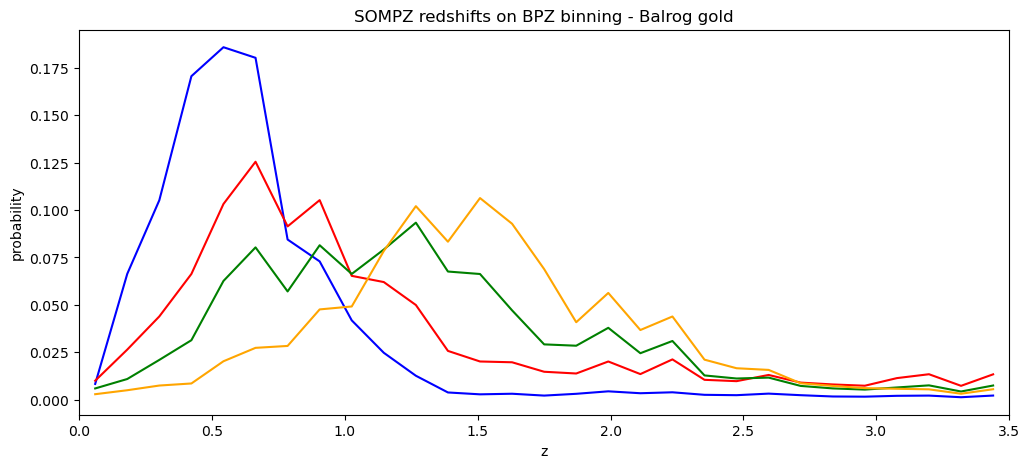

In [98]:
plt.figure(figsize=(12,5))
plt.xlabel('z')
plt.ylabel('probability')
plt.title('SOMPZ redshifts on BPZ binning - Balrog gold')
plt.xlim(0, 3.5)
#plt.xticks(ticks=np.arange(0,1.5,.1))
colors = ['blue', 'red', 'green', 'orange']
for i in range(4):
    plt.plot(zs, p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]), c=colors[i])
plt.show()

In [ ]:
#np.savez('/project/chihway/raulteixeira/data/p_z_c_hat_bins_BPZ.npz', np.array(p_z_c_hat_bins))

#np.savetxt('/project/chihway/raulteixeira/data/p_z_c_hat_bins_BPZ.txt', np.array(p_z_c_hat_bins))

### Tomographic Binning with SOMPZ (no external template-fitting code required)

### Mean cell redshift binning

In [99]:
weight_tomo = np.sum(p_z_c_hat*zs, axis=1)
ids = np.argsort(weight_tomo/np.sum(p_z_c_hat, axis=1))
square_wide_len = wide[['COADD_OBJECT_ID', 'cells']].groupby('cells').agg([len])
im_len = square_wide_len[('COADD_OBJECT_ID', 'len')].values
percentages = im_len[ids].cumsum()/np.sum(im_len)

/tmp/jobs/31278716/ipykernel_215192/1658099213.py:2: RuntimeWarning: invalid value encountered in divide
  ids = np.argsort(weight_tomo/np.sum(p_z_c_hat, axis=1))


In [100]:
cell_masks = []
for lim1, lim2 in zip([0, .25, .5, .75], [.25, .5, .75, 1.]):
    cell_masks.append(ids[(lim1<percentages) & (percentages<=lim2)])

Text(0.5, 1.0, 'TomoBins - SOMPZ mean $z|\\hat{c}$ Balrog Gold')

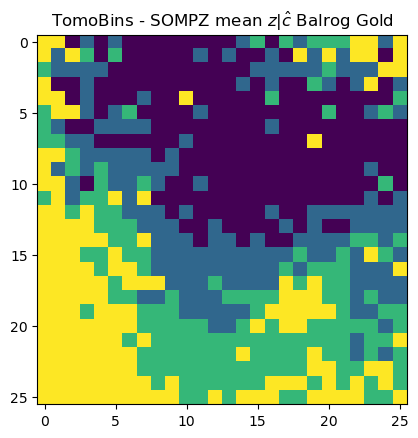

In [101]:
TomoBin4cell = np.empty(n_wide**2)
for i, mask in enumerate(cell_masks):
    TomoBin4cell[mask]=i+1
plt.imshow(TomoBin4cell.reshape(n_wide,n_wide))
plt.title('TomoBins - SOMPZ mean $z|\hat{c}$ Balrog Gold')

In [102]:
p_z_c_hat_bins = [np.sum(p_z_c_hat[cell_masks[i]], axis=0) for i in range(4)]

print([np.sum(p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]) * np.linspace(0, 2, nbins)[:-1]) for i in range(4)])

[0.3156344647497953, 0.5091515416297582, 0.6993499024429222, 0.8820966451023524]


In [103]:
balrog.detected.sum()/len(balrog)

0.5980907772634374

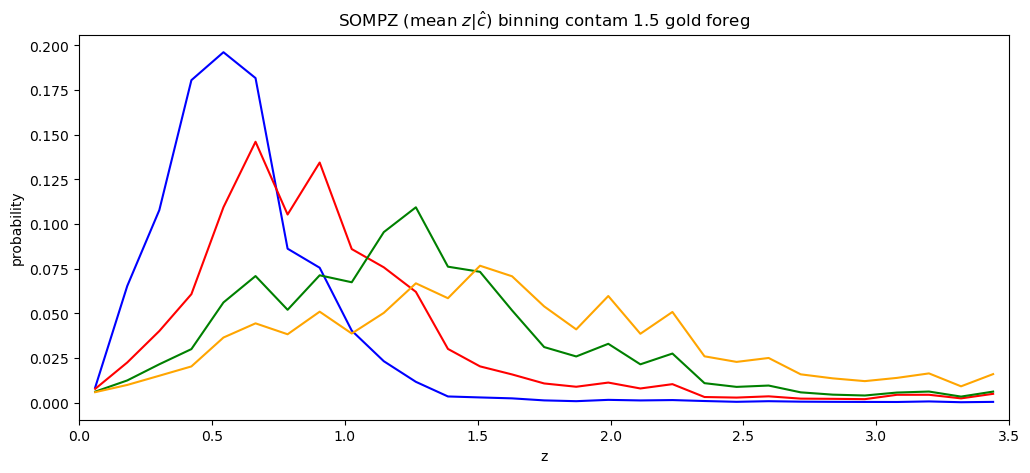

In [105]:
plt.figure(figsize=(12,5))
plt.title('SOMPZ (mean $z|\hat{c}$) binning contam 1.5 gold foreg')
plt.xlabel('z')
#plt.yscale('log')
plt.ylabel('probability')
colors = ['blue', 'red', 'green', 'orange']
#plt.xticks(ticks=np.arange(0, 2.1, 0.25))
plt.xlim(0,3.5)
for i in range(4):
    plt.plot(zs, p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]), c=colors[i])
plt.show()

### Binning algorithm described in Myles, Alarcon 2021

In [33]:
#p_z_c_hat = np.load('/project/chihway/raulteixeira/data/p_z_c_hat_DR3_1_1.npz')['arr_0']
# uncomment if want to save running time

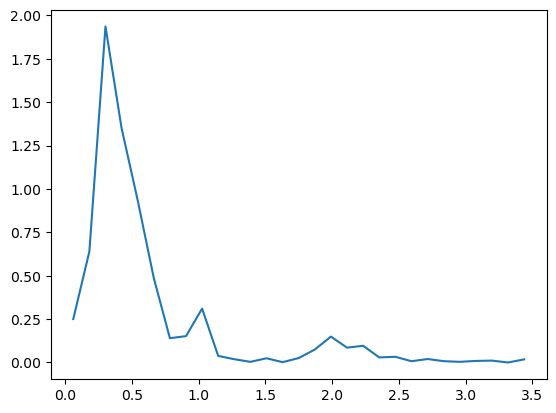

In [33]:
plt.plot(zs, p_z_c_hat[45])

In [35]:
#plt.plot(zs, p_z_c_hat[0])

In [34]:
from scipy.optimize import differential_evolution

In [35]:
#bins_0 = np.concatenate(([0], np.random.normal([0.358, 0.631, 0.872], scale=.03), [2]))
bins_0 = np.concatenate(([0], [0.358, 0.631, 0.872], [2]))
bins_0 = np.round(bins_0, decimals=3)

In [38]:
bins_0

array([0.   , 0.358, 0.631, 0.872, 2.   ])

In [39]:
tb_share(bins=bins_0)

NameError: name 'tb_share' is not defined

In [ ]:
tb_share(bins=bins)

In [66]:
def bin_loss(bins=bins_0):
    bins = np.concatenate(([0], bins, [2]))
    bin_masks = [(bins[i]<zs)&(zs<bins[i+1]) for i in range(4)]
    tb_assign = np.argmax(np.array([np.sum(p_z_c_hat[:,bin_mask], axis=1) for bin_mask in bin_masks]), axis=0)
    tb_norm_counts = [np.sum(p_c_hat.flatten()[tb_assign==i]) for i in range(4)]
    return (np.mean(tb_norm_counts)-.25)**2+np.std(tb_norm_counts)

In [22]:
def tb_share(bins=bins):
    #bins = np.concatenate(([0], bins, [2]))
    print()
    bin_masks = [(bins[i]<zs)&(zs<bins[i+1]) for i in range(4)]
    tb_assign = np.argmax(np.array([np.sum(p_z_c_hat[:,bin_mask], axis=1) for bin_mask in bin_masks]), axis=0)
    tb_norm_counts = [np.sum(p_c_hat.flatten()[tb_assign==i]) for i in range(4)]
    return tb_norm_counts

NameError: name 'bins' is not defined

array([0.26137339, 0.67597248, 0.98768136])

In [140]:
#WRONG
# def bin_loss(bins=bins_0):
#     bin_masks = [(bins[i]<zs)&(zs<bins[i+1]) for i in range(4)]
#     bin_masks = [np.tile(bin_masks[i], n_wide**2).reshape(n_wide**2, 29) for i in range(4)]
#     tb_test = [np.sum(p_z_c_hat[bin_masks[i]].reshape(n_wide**2, bin_masks[i][0].sum())) for i in range(4)]
#     percentages = tb_test/np.sum(tb_test)
#     return np.mean(percentages)-.25+np.std(percentages)

In [112]:
loss_curr = np.inf
best_bins = bins_0
for i in range(10):
    bins_0 = np.random.normal([0.358, 0.631, 0.872], scale=.1)

    n_bins = 4
    result_DE = differential_evolution(bin_loss, bounds=[(0,2), (0,2), (0,2)], x0=bins_0)
    bins = result_DE.x
    
    if result_DE.fun<loss_curr:
        loss_curr = result_DE.fun
        best_bins = bins
print(loss_curr)

0.0407649694750939


In [113]:
best_bins

array([0.57690261, 0.93148575, 1.43780192])

 message: Optimization terminated successfully.
 success: True
     fun: 0.04630449109546237
       x: [ 3.257e-01  5.302e-01  8.185e-01]
     nit: 27
    nfev: 1264
[0.         0.32569316 0.53022721 0.81853787 2.        ]


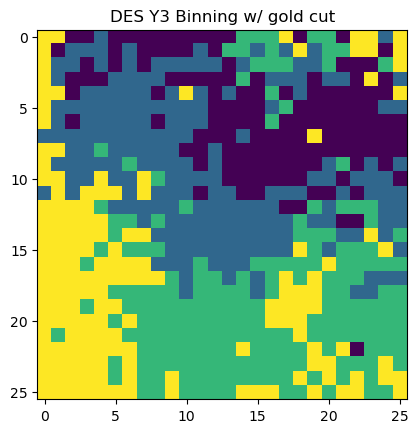

In [86]:
bins_0 = np.random.normal([0.358, 0.631, 0.872], scale=.1)

n_bins = 4
result_DE = differential_evolution(bin_loss, bounds=[(0,zmax), (0,zmax), (0,zmax)], x0=bins_0)
bins = result_DE.x
print(result_DE)
#bins = differential_evolution(bin_loss, bounds=[(0,0), (0,1), (0,1), (2,2)], x0= [0, 0.4, 0.8, 2]).x
bins = np.concatenate(([0], bins, [2]))
#bins=[0.000e+00,  4.230e-01,  6.738e-01,  9.931e-01,  2.000e+00]
bin_masks = [(bins[i]<zs)&(zs<bins[i+1]) for i in range(n_bins)]
bin_masks = [np.tile(bin_masks[i], n_wide**2).reshape(n_wide**2, nbins-1) for i in range(n_bins)]

tb_test = np.array([np.sum(p_z_c_hat[bin_masks[i]].reshape(n_wide**2, bin_masks[i][0].sum()), axis=1) for i in range(n_bins)])

tomo_bins = np.argsort(tb_test.T)[:,-1]

#np.savez('/project/chihway/raulteixeira/data/TomoBins_DESY3_Algo_DELVE_DR3_1_1.npz', tomo_bins)
print(bins)
plt.title('DES Y3 Binning w/ gold cut')
plt.imshow(tomo_bins.reshape(n_wide, n_wide))

In [116]:
p_z_c_hat

array([[0.10569287, 0.19787029, 0.32814019, ..., 0.21356378, 0.11687363,
        0.18208241],
       [0.00177784, 0.00202486, 0.01067075, ..., 0.02234524, 0.04132194,
        0.00318139],
       [0.02486105, 0.43275219, 0.41767174, ..., 0.00392376, 0.00196188,
        0.00147141],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00913447, 0.00927546, 0.00646566, ..., 0.00732974, 0.0048865 ,
        0.0048865 ],
       [0.06520398, 0.03446505, 0.05160844, ..., 0.33716786, 0.15755918,
        0.31589241]])

In [87]:
cell_masks = [tomo_bins==i for i in range(n_bins)]

p_z_c_hat_bins = [np.sum(p_z_c_hat[cell_masks[i]], axis=0) for i in range(n_bins)]

print('mean z per bin', [np.sum(p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]) * zs)\
       for i in range(n_bins)])

mean z per bin [0.39739676544793134, 0.5167901317479752, 0.6981248485227821, 0.8785173817179063]


In [88]:
i=0
np.sum(p_z_c_hat_bins[i]*p_z_c_hat_bins[i+1])/np.sum(p_z_c_hat_bins[i])/np.sum(p_z_c_hat_bins[i+1])

0.12454046385935208

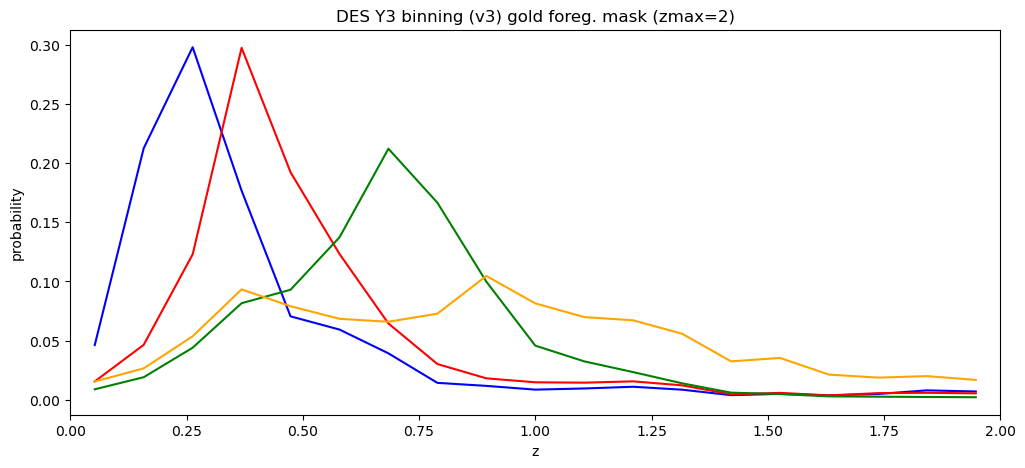

In [89]:
plt.figure(figsize=(12,5))
plt.title(f'DES Y3 binning (v3) gold foreg. mask (zmax={zmax})')
plt.xlabel('z')
#plt.yscale('log')
plt.ylabel('probability')
colors = ['blue', 'red', 'green', 'orange']
#plt.xticks(ticks=np.arange(0, 1.7, 0.1))
plt.xlim(0,2)
for i in range(n_bins):
    plt.plot(zs, p_z_c_hat_bins[i]/np.sum(p_z_c_hat_bins[i]), c=colors[i])
plt.show()

In [72]:
for i in     
    wide[['COADD_OBJECT_ID', 'wide_cells']][cell_masks[i]]=i+1

array([3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 3, 0, 2, 3, 0,
       3, 3, 1, 3, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 1, 2, 0,
       3, 0, 2, 2, 3, 3, 0, 3, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 2, 3, 3, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 2, 0, 1, 1, 1, 0, 1, 0, 0, 3, 0, 1, 3, 3, 0, 0, 1, 1,
       1, 1, 0, 1, 3, 1, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 3, 3, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 3, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 3, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 0, 1, 1, 2, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 3, 3, 0, 0,
       3, 1, 1, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 0, 1, 0, 0,

In [ ]:
#np.savez('/project/chihway/raulteixeira/data/p_z_c_hat_bins_SOMPZ.npz', np.array(p_z_c_hat_bins))

In [ ]:
#np.savetxt('/project/chihway/raulteixeira/data/p_z_c_hat_bins_SOMPZ.txt', np.array(p_z_c_hat_bins))

In [20]:
tomo_cells = [np.arange(n_wide**2)[cell_masks[i]] for i in range(4)]

In [21]:
wide['Tomo_Bin'] = np.zeros(len(wide))
for i, cells in enumerate(tomo_cells):
    wide['Tomo_Bin'][np.isin(wide['cells'], cells)] = i

/tmp/jobs/31083417/ipykernel_240594/788202748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wide['Tomo_Bin'][np.isin(wide['cells'], cells)] = i
/tmp/jobs/31083417/ipykernel_240594/788202748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wide['Tomo_Bin'][np.isin(wide['cells'], cells)] = i
/tmp/jobs/31083417/ipykernel_240594/788202748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wide['Tomo_Bin'][np.isin(wide['cells'], c

### Bootstrapping

In [22]:
BT_TB3 = np.random.choice(wide['COADD_OBJECT_ID'][].values, size=int(1e8)*)

In [23]:
BT_TB3 

array([7014348313, 7052155497, 7251013006, ..., 7104803073, 7114942970,
       7231729025])

In [ ]:
BT_TB3 

In [ ]:
np.rec.array()

In [ ]:
wide.to_csv('/')

### Deep2Wide plots (sanity checks!)

In [ ]:
def group_i_deep(i, max_d, n):
    ps = np.array(np.unravel_index(np.arange(0,n**2), (n,n), order='F'))
    p = np.array(np.unravel_index(i, (n,n), order='F'))
    d = np.sum(np.abs(ps-p[:, None]),axis=0)
    return np.arange(0,n**2)[d<=max_d]

In [ ]:
fig, axes = plt.subplots(nx, ny, figsize=(12, 24))
i_deeps = np.random.randint(0,n_deep**2, (nx, ny))
for i_deep in i_deeps:

    idx_deep = group_i_deep(i_deep, max_d=2, n=n_deep)

    plt.title(f'Deep SOM cell: {i_deep-1}')

    im = np.sum(p_cchat[:,idx_deep],axis=1).reshape(n_wide,n_wide)

    im /= np.sum(im)

    plt.title(f'Deep SOM cell: {i_deep-1}')
    plt.imshow(im, norm=mpl.colors.LogNorm())
    plt.colorbar()
    plt.show()